# Fixes need to do:
## we need to fix the vanishing calcaulations in the nets, maybe amplifying all the values by some factor (100 maybe to get to normal values) and in the end we can just shrink the result (only the output) in the real test

## Add the normalization (around 0) of the the outputs - if the nets doesn't do it naturally

## Maybe initialize the weights to a big number because all the values are very small

## Add the scipy snippet to resample the vectors to be the same vector (DONE)

## MAYBE change the fully connected layers to go from each cell to an output instead of merging all the outputs to a big vector and forwarding it through a big FC

# Libraries Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import string 
# from google.colab import drive
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import *
from Nets import device
import Nets
import hyper_parameters as hp
import Data_Handling as hand
import training

checking for device (GPU)

In [2]:
# drive.mount('/content/drive')
print('training on: ',device)


training on:  cuda


In [5]:
mod = Nets.load_model_from_mode('doppler', True, 0.5, 0.00011)

In [3]:
pepe = Nets.load_model_from_mode('spectra', True, 0.7, 5e-6).to(device)

In [3]:
pepe = Nets.SpectraNet().to(device)

# Data Pre-Processing

In [4]:
def get_sizes(train, test, val):
    iterator = iter(train)
    it1 = next(iterator)
    obs, ground_truth, sys_id, times, velocities = it1
    print(obs.shape, obs.type()) # observations: Obs_amount X wave_amount
    print(ground_truth.shape, ground_truth.type()) # Ground Truth Spectras: stars_amount (2) X wave_output_amount
    print(sys_id) # System ID: int
    print(times.shape, times.type()) # Time of sample: Obs_amount
    print(velocities.shape, velocities.type()) # Velocities per sample time: stars_amount (2) X Obs_amount
    Obs_amount, wave_amount, wave_output = obs.shape[0], obs.shape[1], ground_truth.shape[1]
    return Obs_amount, wave_amount, wave_output

In [4]:
# dataset = SpectraDataset()
train_loader, test_loader, val_loader, std_dict = getLoader(seed=1)

In [5]:
print(std_dict)

{'min source': 4992.544013409346, 'max source': 5087.104146943163, 'min target': 4990.122000000003, 'max target': 5079.972000001964, 'source len': 7500, 'target len': 1700, 'vector source': array([4992.54401341, 4992.55662311, 4992.56923281, ..., 5087.07892754,
       5087.09153724, 5087.10414694]), 'vector target': array([4990.122     , 4990.17488405, 4990.2277681 , ..., 5079.8662319 ,
       5079.91911595, 5079.972     ])}


# The Training - SpectraNet
### 1. sum the losses
of each spectra and then backprop - I think it will backprop in the net twice (for each spectra)
### 2. train 
the first layers until spectra1 and then only the last FC on the spectra2 with all the others params grad's are off

## Training Parameters:

In [34]:
del spectraModel
torch.cuda.empty_cache()

## Train new Model

In [24]:
epochs_amount = 3
# spectraModel_test_big_drop = SpectraNet(drop=0.7).to(device)
opt = optim.Adam(pepe.parameters(), weight_decay = 1e-1,lr=5e-6) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
pepe, train_loss, val_loss = training.train_spectra1(pepe, opt, sched, train_loader, val_loader, epochs=epochs_amount)

Epoch: 1/3... Train Loss: 0.4135... Validation Loss: 0.3780... LR: [5e-06]
Epoch: 2/3... Train Loss: 0.3591... Validation Loss: 0.3459... LR: [5e-06]
Epoch: 3/3... Train Loss: 0.3355... Validation Loss: 0.3245... LR: [5e-06]


In [84]:
save_model_with_checkpoint(spectraModel_test_big_drop, lr=5e-6, model_type='spectra')

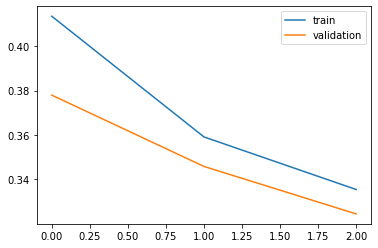

In [25]:
plt.figure()
plt.plot(range(epochs_amount), train_loss, label = 'train')
plt.plot(range(epochs_amount), val_loss, label = 'validation')
plt.legend()

### Snippet to draw and test shape closeness

test loss: 0.32446981966495514
tensor(6.0734e-09, device='cuda:0')
tensor(0.1089, device='cuda:0')


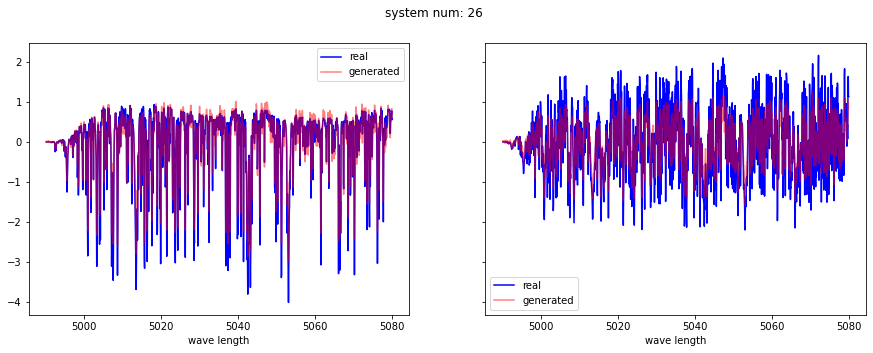

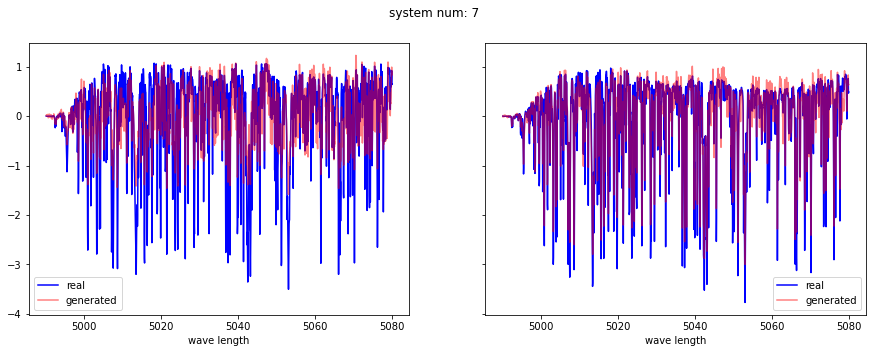

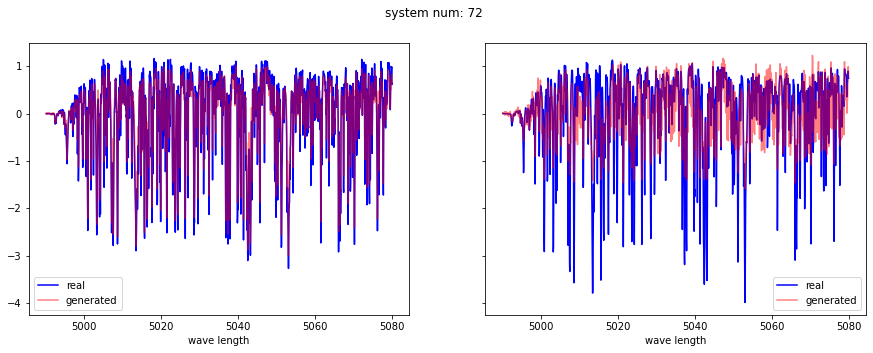

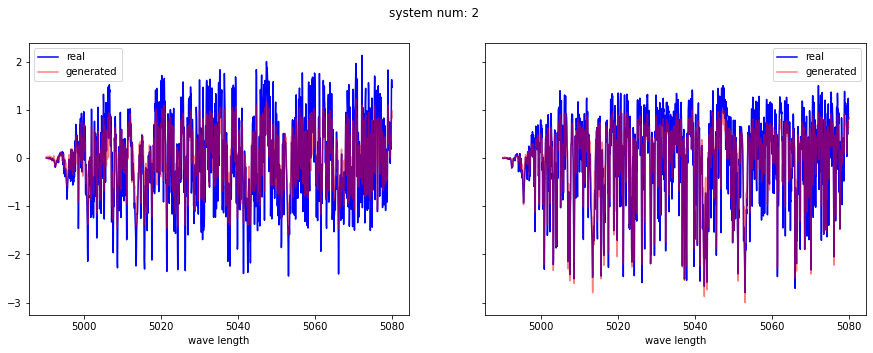

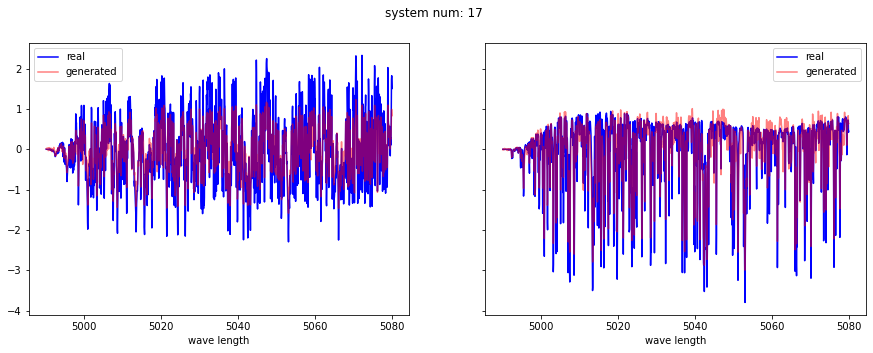

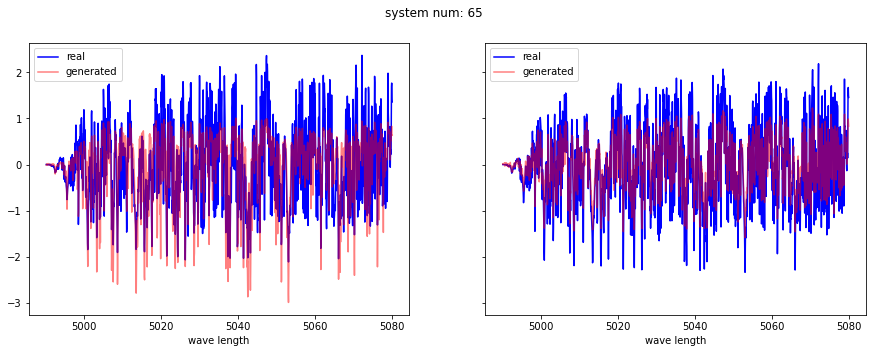

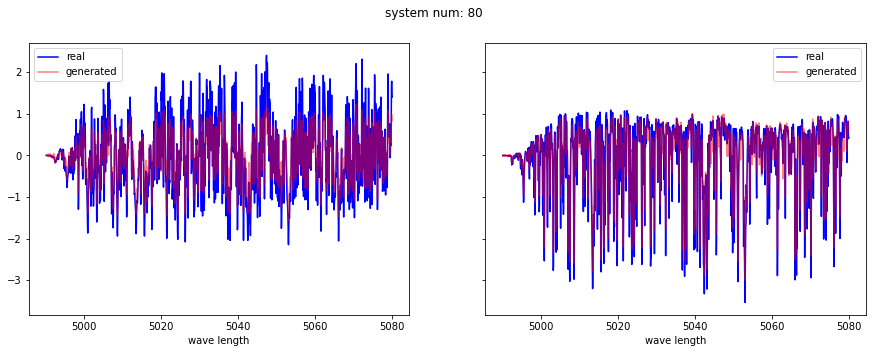

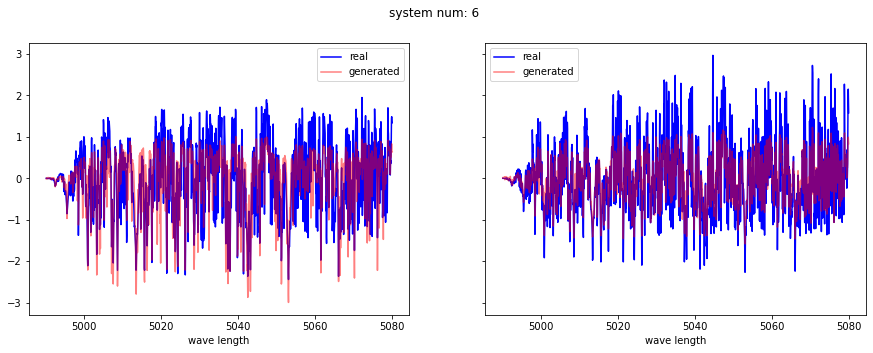

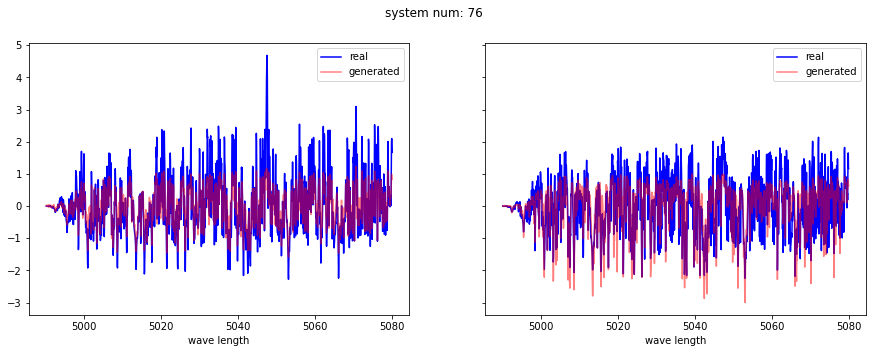

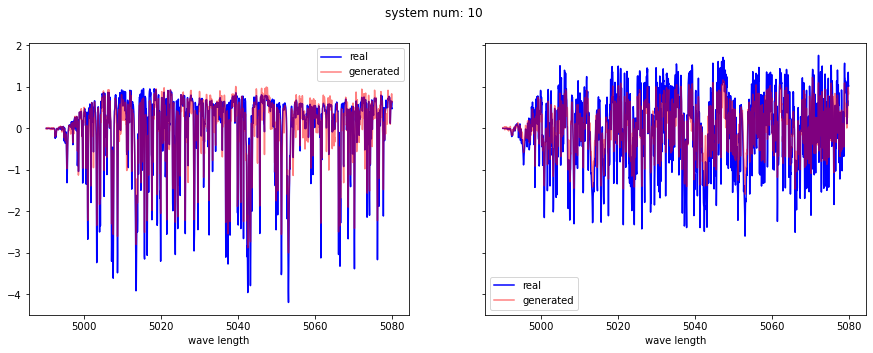

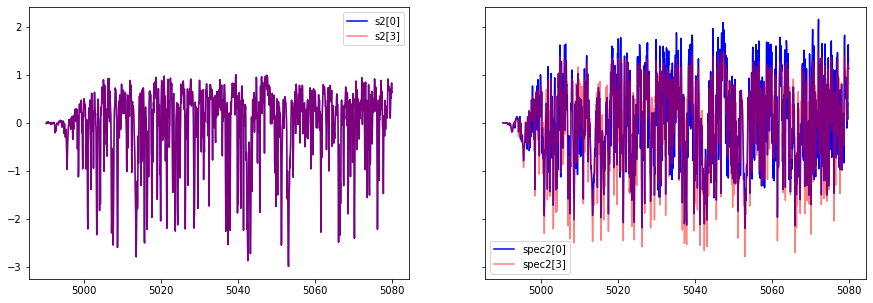

In [27]:
loss = nn.MSELoss(reduction = 'mean')
pepe.eval()
length = 90
skip = True
s1 = list(range(length))
s2 = list(range(length))
spec1 = list(range(length))
spec2 = list(range(length))
j = 0
k = j+3
running_loss = 0
with torch.no_grad():
    h = pepe.init_hidden()
    for i, (obs,specs,system,_,_) in enumerate(val_loader):
#         if i >= 10:
#             break
        specs = specs.to(device)
        #spec1[i], spec2[i] = normalize_tensor(specs[0,:]), normalize_tensor(specs[1,:])
        spec1[i], spec2[i] = specs[0,:], specs[1,:]
        s1[i],s2[i],h = pepe(hand.split_vector_to_seqs(obs, seq_length=500, seq_amount=7500//500).to(device), h)
        #s1[i] = normalize_tensor(s1[i])
        #s2[i] = normalize_tensor(s2[i])
        running_loss += training.calc_loss(loss, s1[i],s2[i],spec1[i].view(1,-1),spec2[i].view(1,-1)).item()
        if i < 10:
            hand.display_graphs(loss,s1[i][0],s2[i][0],spec1[i][:],spec2[i][:],std_dict['vector target'],system)

print(f'test loss: {running_loss / len(val_loader)}')
loss = nn.MSELoss(reduction = 'mean')
print(loss(s2[j], s2[k]))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15, 5))
ax1.plot(std_dict['vector target'], s2[j][0].cpu().detach().numpy(), color='blue', label = f's2[{j}]')
ax1.plot(std_dict['vector target'], s2[k][0].cpu().detach().numpy(), alpha = 0.5, color='red', label = f's2[{k}]')
ax1.legend()
print(loss(spec2[j], spec2[k]))
ax2.plot(std_dict['vector target'], spec2[j].cpu().detach().numpy(), color='blue', label = f'spec2[{j}]')
ax2.plot(std_dict['vector target'], spec2[k].cpu().detach().numpy(), alpha = 0.5, color='red', label = f'spec2[{k}]')
ax2.legend()
# print(loss(s2[0], s2[1]))
# print(loss(spec2[0], spec2[1]))

tensor([[4.0049e-07, 1.7829e-06, 4.1127e-06,  ..., 5.4825e-01, 3.8845e-01,
         3.8846e-01],
        [4.4857e-07, 1.9827e-06, 4.5738e-06,  ..., 8.8592e-01, 6.7519e-01,
         6.6624e-01]], dtype=torch.float64)
tensor(0.3200, dtype=torch.float64)


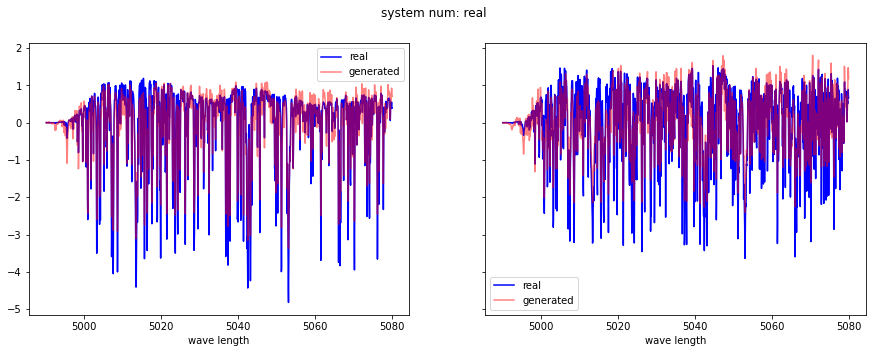

In [53]:
spectraModel_test_big_drop.eval()
real = get_real_loader(std_dict)
print(real[1])
with torch.no_grad():
    loss_function = nn.MSELoss(reduction = 'mean')
    h = spectraModel_test_big_drop.init_hidden()
    target = real[1].to(device)
    s1,s2,h = spectraModel_test_big_drop(split_vector_to_seqs(real[0], seq_length=500, seq_amount=7500//500).to(device), h)
    display_graphs(loss,s1[0],s2[0],target[0,:],target[1,:],std_dict['vector target'])
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize = (15, 5))
    #ax1.plot(real[1][0,:].cpu().numpy(), color='blue')
    #ax2.plot(real[1][1,:].cpu().numpy(), color='blue')
    #ax3.plot(s2[0].cpu().numpy(), color='red')
    #ax4.plot(s1[0].cpu().numpy(), color='red')
    print(calc_loss(loss_function,s1.cpu(),s2.cpu(),target[0,:].view(1,-1).cpu(), target[1,:].view(1,-1).cpu()))

In [110]:
print(std_dict)

{'min source': 4991.797238496773, 'max source': 5088.175939566208, 'min target': 4990.122000000003, 'max target': 5089.85200000218, 'source len': 7500, 'target len': 1700, 'vector source': array([4991.7972385 , 4991.8100907 , 4991.82294291, ..., 5088.15023515,
       5088.16308736, 5088.17593957]), 'vector target': array([4990.122     , 4990.18069923, 4990.23939847, ..., 5089.73460153,
       5089.79330077, 5089.852     ])}


In [17]:
test = SpectraNet()
req_grad = False
opt = torch.optim.Adam(test.parameters())
for param in test.parameters():
    if param.size() == torch.Size([1995, 1995]): # the params from here are the last layer and its bias
        req_grad = True
    param.requires_grad = req_grad
print(opt)
# for param in opt.params:
#     print(f'param: required grad: {param.requires_grad}, size: {param.size()}')

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [6]:
doppy = Nets.DopplerNet(batch_size = 40).to(device) #40 because there are 20 observation but 2 systems to predict so: 20*2
opt = optim.Adam(doppy.parameters(), weight_decay=1e-2, lr=0.00011)
epochs_amount = 15
lambda_lr = lambda epoch: 0.5 if epoch+1 > (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
schedu = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
print(doppy)
doppy, tr, vl = training.train_doppler25(pepe, doppy, opt, schedu, train_loader, val_loader, epochs=epochs_amount)

DopplerNet(
  (rnn_doppler): LSTM(400, 400, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)
Epoch: 1/15... Train Loss: 115.1431... Validation Loss: 123.6657... LR: [0.00011]
Epoch: 2/15... Train Loss: 115.0933... Validation Loss: 123.5382... LR: [0.00011]
Epoch: 3/15... Train Loss: 114.0763... Validation Loss: 118.5629... LR: [0.00011]
Epoch: 4/15... Train Loss: 102.4267... Validation Loss: 88.9803... LR: [0.00011]
Epoch: 5/15... Train Loss: 73.8916... Validation Loss: 62.9585... LR: [0.00011]
Epoch: 6/15... Train Loss: 54.8320... Validation Loss: 39.7477... LR: [0.00011]
Epoch: 7/15... Train Loss: 45.9188... Validation Loss: 25.5502... LR: [0.00011]
Epoch: 8/15... Train Loss: 37.3685... Validation Loss: 19.6789... LR: [0.00011]
Epoch: 9/15... Tra

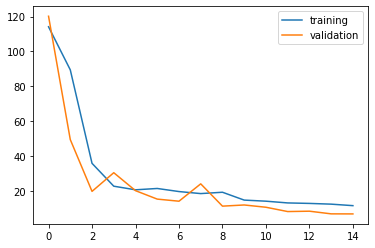

In [6]:
plt.figure()
plt.plot(tr, label = 'training')
plt.plot(vl, label = 'validation')
plt.legend()

5
torch.Size([2, 20])


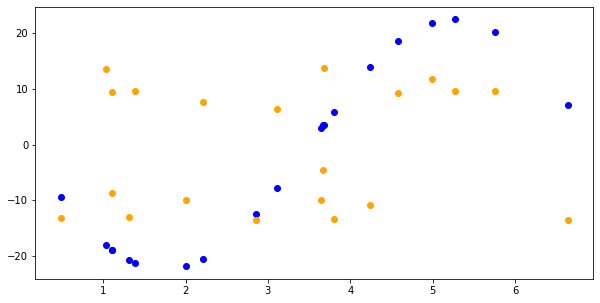

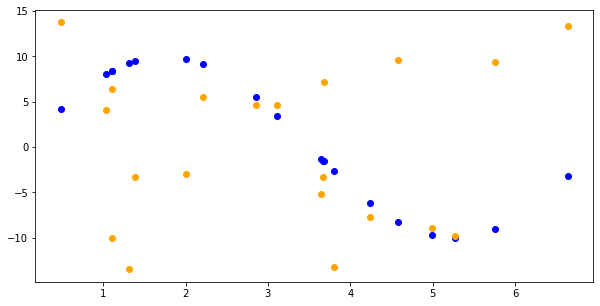

In [10]:
it = iter(val_loader)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
# tup = next(it)
repeat_time = 7
print(len(tup))
doppy.eval()
with torch.no_grad():
#     spec1, spec2, _ = spectraModel(split_vector_to_seqs(tup[0]).to(device), spectraModel.init_hidden())
#     inp = torch.cat((tup[0].repeat(2,1),torch.cat((spec1.cpu().repeat(20,1), spec2.cpu().repeat(20,1)), 0)), 1)
    inp = torch.cat((tup[0].repeat(2,1),torch.cat((tup[1][0,:].repeat(20,1), tup[1][1,:].repeat(20,1)), 0)), 1)
    predicted, _ = doppy(hand.split_vector_to_seqs(inp, doppy.seq_size, doppy.seq_amount,
                                                    doppy.combine_wave_input).to(device), doppy.init_hidden())
    predicted = predicted.view(2,20)
    print(predicted.shape)
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3]%8, predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3]%8, tup[4][0,:].numpy(), color='blue')
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], tup[4][1,:].numpy(), color='blue')
    plt.figure(figsize = [10,5])
#     plt.scatter(tup[3], predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, tup[4][0,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[0,:].cpu().numpy(), color='orange')
    plt.figure(figsize = [10,5])
    plt.scatter(tup[3]%repeat_time, tup[4][1,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[1,:].cpu().numpy(), color='orange')


In [40]:
dop_new = load_model_from_mode('doppler', True, drop=0.5, lr=0.00011)

total loss: 4.433814825731165


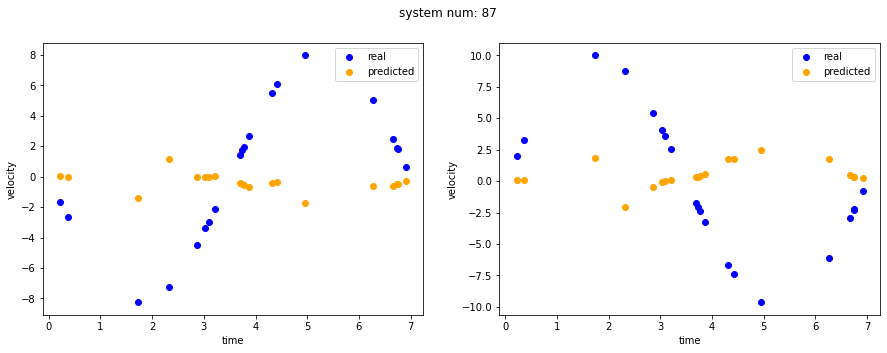

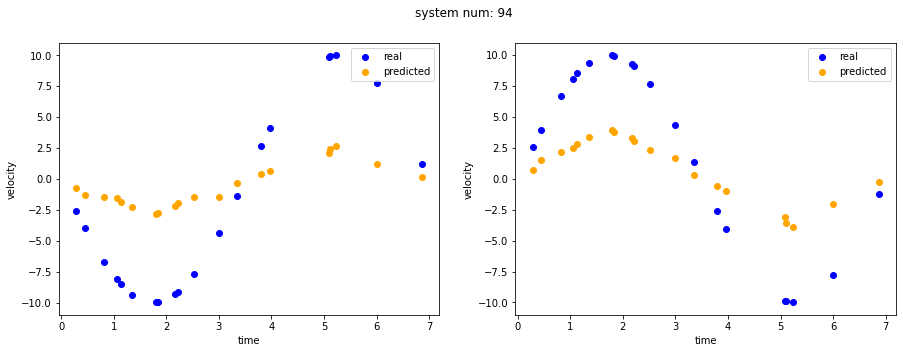

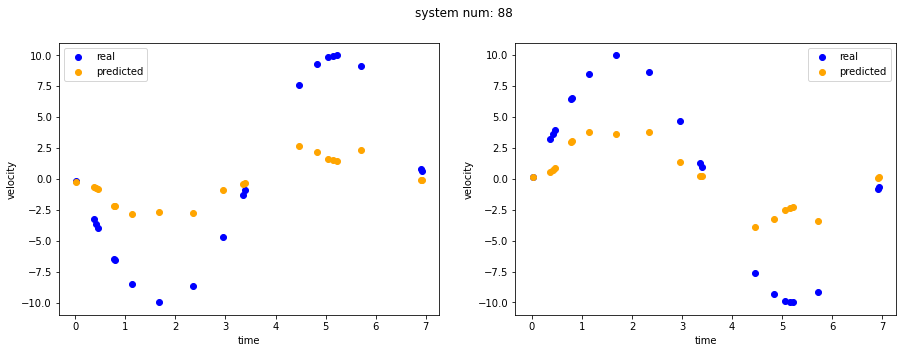

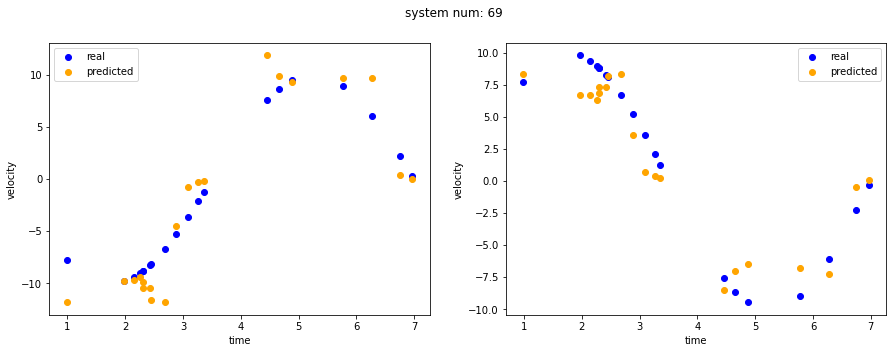

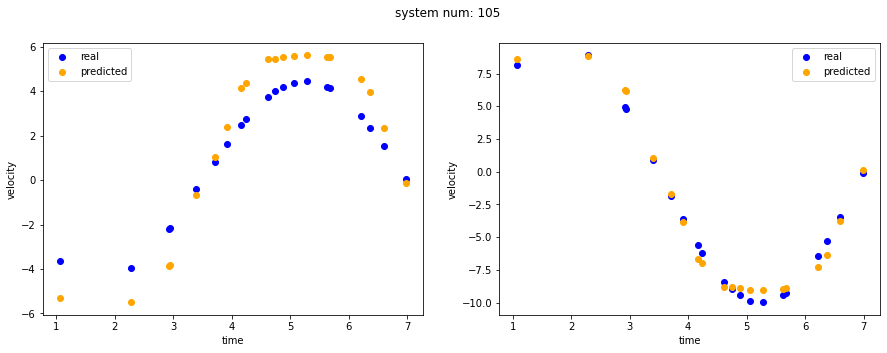

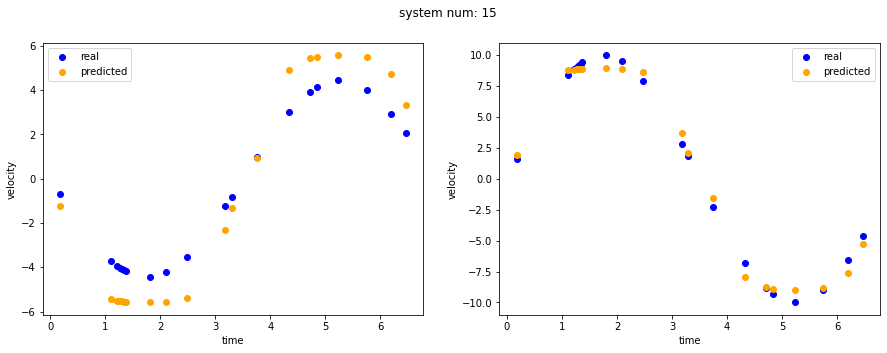

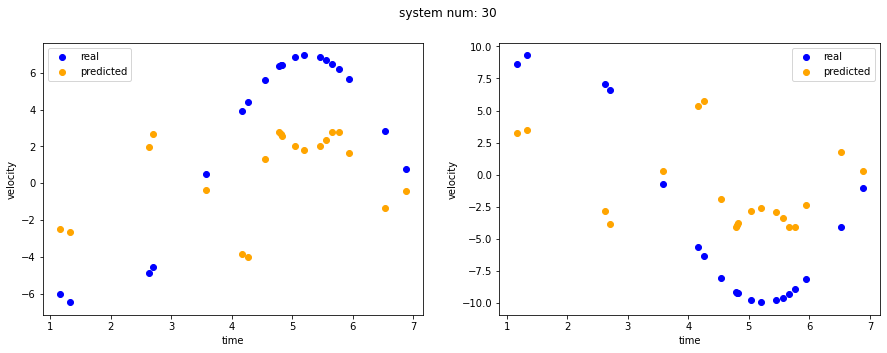

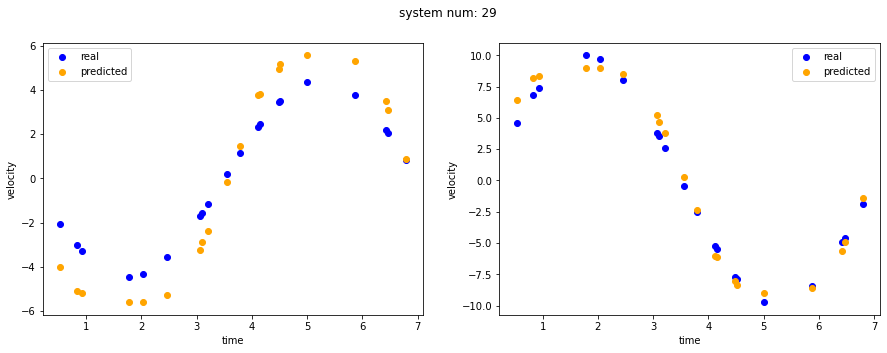

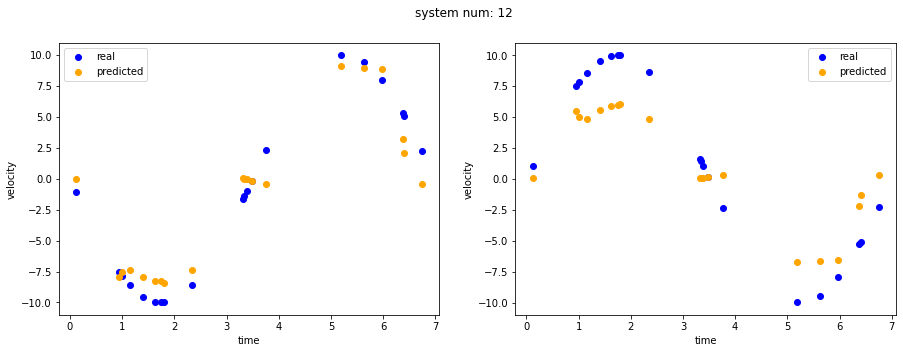

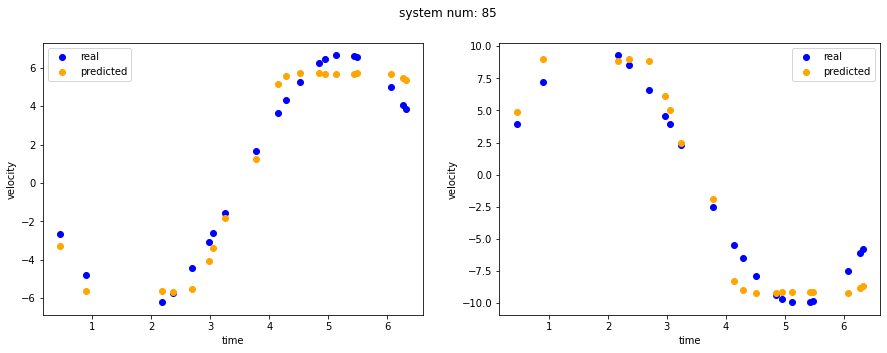

In [11]:
# dop_new = dop_new.to(device)
loss_function = nn.MSELoss(reduction = 'mean')
repeat_time = 7
doppy.eval()
with torch.no_grad():
    running_loss = 0
    for i, (obs, specs, system_id, times, velocities) in enumerate(test_loader):
        doppler_hidden = doppy.init_hidden()

        doppler_input = torch.cat((obs.repeat(2,1),
                                   torch.cat(
                                       (specs[0,:].repeat(20,1), specs[1,:].repeat(20,1)),0)),1)

        doppler_input = hand.split_vector_to_seqs(doppler_input, doppy.seq_size, doppy.seq_amount,
                                             doppy.combine_wave_input).to(device)
        output, doppler_hidden = doppy(doppler_input, doppler_hidden)
        #output = output.view(2,20)
        output = torch.transpose(output, 0,1)
        velocities = velocities.to(device)
        loss = loss_function(output[0,:], velocities[0,:]) + loss_function(output[1,:], velocities[1,:])
#         loss = calc_loss(loss_function, output[0,:],output[1,:],velocities[0,:], velocities[1,:])
        running_loss += loss.item()
        if i < 10:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
            ax1.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
            ax1.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
            ax2.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
            ax2.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
            f.suptitle(f'system num: {system_id}')
            ax1.set_xlabel('time')
            ax2.set_xlabel('time')
            ax1.set_ylabel('velocity')
            ax2.set_ylabel('velocity')
            ax1.legend()
            ax2.legend()

#             f2, (ax3, ax4) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
#             ax3.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
#             ax3.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
#             ax4.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
#             ax4.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
#             f2.suptitle(f'system num: {system_id}')
#             ax3.set_xlabel('time')
#             ax4.set_xlabel('time')
#             ax3.set_ylabel('velocity')
#             ax4.set_ylabel('velocity')
#             ax3.legend()
#             ax4.legend()
    print(f'total loss: {running_loss/len(train_loader)}')

In [14]:
Nets.save_model_with_checkpoint(doppy, 0.00012, 'doppler')

tensor([[4.0049e-07, 1.7829e-06, 4.1127e-06,  ..., 5.4825e-01, 3.8845e-01,
         3.8846e-01],
        [4.4857e-07, 1.9827e-06, 4.5738e-06,  ..., 8.8592e-01, 6.7519e-01,
         6.6624e-01]], dtype=torch.float64)


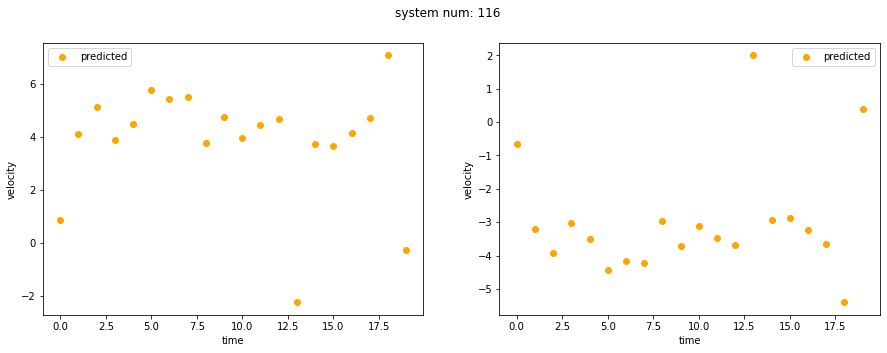

In [125]:
real = get_real_loader(std_dict)
times = range(20)
repeat = 
print(real[1])
with torch.no_grad():
    loss_function = nn.MSELoss(reduction = 'mean')
    h = dop_new.init_hidden()

    doppler_input = (torch.cat((real[0].repeat(2,1),
                               torch.cat(
                                   (real[1][0,:].repeat(20,1), real[1][1,:].repeat(20,1)),0)),1)).type(torch.FloatTensor)

    doppler_input = split_vector_to_seqs(doppler_input, dop_new.seq_size, dop_new.seq_amount,
                                         dop_new.combine_wave_input).to(device)
    output, doppler_hidden = dop_new(doppler_input, doppler_hidden)
    #output = output.view(2,20)
    output = torch.transpose(output, 0,1)
    velocities = velocities.to(device)
    running_loss += loss.item()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
    ax1.scatter(times, output[0,:].cpu().numpy(), label='predicted', color='orange')
    ax2.scatter(times, output[1,:].cpu().numpy(), label='predicted', color='orange')
    f.suptitle(f'system num: {system_id}')
    ax1.set_xlabel('time')
    ax2.set_xlabel('time')
    ax1.set_ylabel('velocity')
    ax2.set_ylabel('velocity')
    ax1.legend()
    ax2.legend()

# Test Functions and Code Slices

In [ ]:
b = torch.randn(4,52)
print(b.size())
b = b[:, :50]
print(b.size())
seq_temp = 5
print(b.dim)
b = b.view(-1, b.size()[-1]//seq_temp, seq_temp)
print(b.size())
b.view

In [ ]:
dataloader = getLoader()
test = next(iter(dataloader))
for item in test:
    if type(item) is int:
        print(item)
    else:
        if item.size()[-1] >= 50:
            item = split_vector_to_seqs(item)
            item = combine_seqs_to_vector(item)
        print(item.shape)

In [ ]:
a = torch.randn(5,5)
z = torch.zeros(5,2)
print(torch.cat((a, z), 1))
print(a.size(), a)
print(a[-5:])

tr = torch.zeros(20, 153, 50)
tr = tr.view(-1, 153*50)
print(tr.size())

In [ ]:
check = torch.ones(3)
print(f'check: {3 in check}')

In [ ]:
train, test, val = getLoader()

for a,b,c,d,e in train:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is train')
for a,b,c,d,e in test:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is test')
for a,b,c,d,e in val:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is val')

In [ ]:
def find_factors(num: int):
    divs = []
    for div in range(5,num//2, 5):
        if num%div == 0:
            divs.append(div)
    print(divs)

In [ ]:
find_factors(9200)

In [59]:
a = torch.randint(40,(20,2))
b1, b2 = torch.randint(40,(1,2)), torch.randint(40,(1,2))
# b.fill_(a)
print(a.shape)
print(b1.shape, b2.shape)
doppler_input = torch.cat((a.repeat(2,1), torch.cat((b1.repeat(20,1), b2.repeat(20,1)), 0)), 1)
print(type(doppler_input), len(doppler_input), doppler_input.shape)

torch.Size([20, 2])
torch.Size([1, 2]) torch.Size([1, 2])
<class 'torch.Tensor'> 40 torch.Size([40, 4])
